In [1]:
import sys
import math
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy.ndimage
import scipy.stats

In [97]:
def plot_img(img, show = True):

    fig = plt.figure(figsize = (8,6))
    plt.imshow(img, interpolation = 'none')
    #plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()

def plot_spectrum(img, show = True):
    vec = np.reshape(img, (-1,3))
    palette, counts = np.unique(vec, axis=0, return_counts=True)
    idx   = np.argsort(counts)
    palette = np.array(palette)[idx]
    counts = np.array(counts)[idx]
    palette = palette[::-1]
    counts = counts[::-1]

    #pltcolor - matplot lib accept flot tuples only
    pltcolor = palette / 256;

    print("Number of colors: ", len(counts))
    #draw color distribution
    y_pos = np.arange(len(counts))
    plt.bar(y_pos, counts, align='center', alpha=0.5, color = pltcolor)
    if show:
        plt.show()



This is the best option by now.

In [367]:
a = [[1, 9], [13,25], [2, 17], [3, 59]]
print(np.amax(a, axis=1))

[ 9 25 17 59]


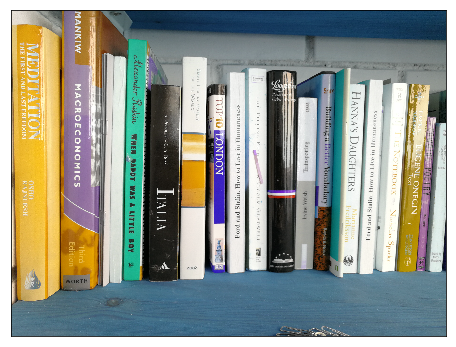

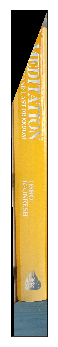

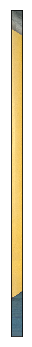

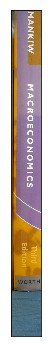

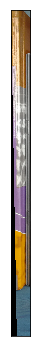

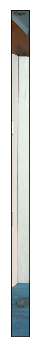

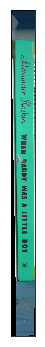

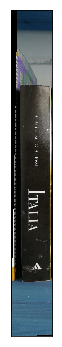

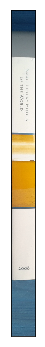

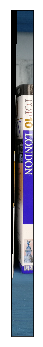

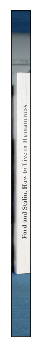

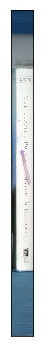

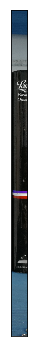

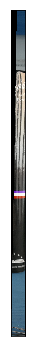

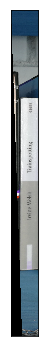

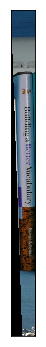

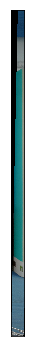

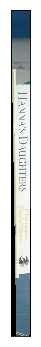

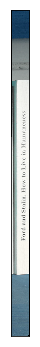

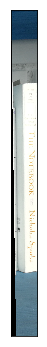

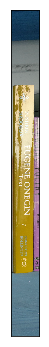

In [380]:
def crop_and_rotate(img, contour, rX, rY, theta):

    # rotate img
    if theta > np.pi/2.0:
        theta = theta - np.pi
        
    rows,cols = img.shape[0], img.shape[1]
    
    contour[:,:,0] = contour[:,:,0] * cols
    contour[:,:,1] = contour[:,:,1] * rows
    rX = int(rX * cols)
    rY = int(rY * rows)
    
    contour = np.int0(contour)
    
    M = cv2.getRotationMatrix2D((rX,rY), theta/np.pi*180, 1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))

    # rotate contour
    contour_rot = np.int0(cv2.transform(contour, M))[0]    
    contour_rot[contour_rot < 0] = 0
    
    mask = np.zeros(img.shape[0:2]) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, np.array([contour_rot]), -1, 255, -1)
    img_masked = np.zeros_like(img_rot) # Extract out the object and place into output image
    img_masked[mask == 255] = img_rot[mask == 255]

    x,y,w,h = cv2.boundingRect(contour_rot)
    
    # crop
    img_crop = img_masked[y:y+h, x:x+w]

    return img_crop

def edges(img):
    blurred = cv2.GaussianBlur(img,(9,9), 0)
    res = cv2.Canny(blurred,10,200)
    return res

IMAGEFILE="shelves/7.jpg"
#img = imread(IMAGEFILE)
oimg = cv2.imread(IMAGEFILE)
img = cv2.resize(oimg, dsize=(0,0), fx=0.1, fy=0.1)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

res = edges(imgray)

lines = cv2.HoughLines(res,rho = 1,theta = 1*np.pi/180,threshold = 80)

#lines = lines[lines[:,0,0].argsort()]
h = res.shape[0]
w = res.shape[1]

lines1 = [] 
for l in lines:
    rho = l[0, 0]
    theta = l[0, 1]
    if (theta > np.pi*0.85 or theta < np.pi*0.15):
        x1 = int(rho / np.cos(theta))
        x2 = int(x1 - h * np.tan(theta))
        y1 = 0
        y2 = h-1
        
        rX = int((x1+x2)/2)
        rY = int((y1+y2)/2)
        
        if x1 < 0:
            y1 = int(x1 / np.tan(theta))
            x1 = 0

        if x1 >= w:
            y1 = int((x1-w+1) / np.tan(theta))
            x1 = 0

        if x2 < 0:
            y2 = int(h + x2 / np.tan(theta))
            x2 = 0

        if x2 >= w:
            y2 = int(h + (x2-w+1) / np.tan(theta))
            x2 = 0

        #cv2.line(res, (x1,y1), (x2,y2), 128, 1)
        lines1.append([x1, y1, x2, y2, rX, rY, theta]);       

lines1 = np.array(lines1)
lines1 = lines1[lines1[:,4].argsort()]

contours = []
first = True
for l in lines1:
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    rX = l[4]
    rY = l[5]
    theta = l[6]
    
    if first:
        p_x1 = x1
        p_y1 = y1
        p_x2 = x2
        p_y2 = y2
        p_rX = rX
        first = False
    elif rX - p_rX > 10:
        book = crop_and_rotate(oimg, np.array([[[p_x1/w, p_y1/h], [x1/w,y1/h], [x2/w, y2/h], [p_x2/w, p_y2/h]]]), rX/w, rY/h, theta)
        plot_img(book, show=True)
        cv2.imwrite('shelves/7-'+str(int(rX))+'.jpg', book)
        p_x1 = x1
        p_y1 = y1
        p_x2 = x2
        p_y2 = y2
        p_rX = rX

#img2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)